<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_vscode_branch/HW12/HW12_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install python3-opengl
!apt install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libglu1-mesa
Suggested packages:
  libgle3 python3-numpy
The following NEW packages will be installed:
  freeglut3 libglu1-mesa python3-opengl
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 824 kB of archives.
After this operation, 8,092 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglu1-mesa amd64 9.0.2-1 [145 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-opengl all 3.1.5+dfsg-1 [605 kB]
Fetched 824 kB in 0s (2,078 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../freeglut3_2.8.1-6_amd64.deb ...
Unpacking freeglut3:am

In [2]:
!pip install pyvirtualdisplay
!pip install swig
# !pip install box2d-kengz
!pip install gym[box2d]
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376100 sha256=aa0532e6fd8edd1b556962c17553b93b61b26047114e38fa86a559f3899812ac
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [3]:
%%capture
from pyvirtualdisplay import Display
# if visible , backend = "xephyr",else backend = "xvfb"
virtual_display = Display(visible=False, size=(1400, 900))
virtual_display.start()

In [4]:
import torch
import numpy as np
import random
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [5]:
%%capture
import gym
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

In [6]:
import time
start = time.time()
print(env.observation_space) # 8-dim of vectors
print(env.action_space) # Discrete(4): 4 kinds of actions
initial_state = env.reset()
print(initial_state)
random_action = env.action_space.sample()
print(random_action)
observation, reward, done, info = env.step(random_action)
print(done)
print(reward)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Discrete(4)
[-1.2619973e-03  1.3984586e+00 -1.2784091e-01 -5.5384123e-01
  1.4691149e-03  2.8957864e-02  0.0000000e+00  0.0000000e+00]
3
False
-1.0511407416545058


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


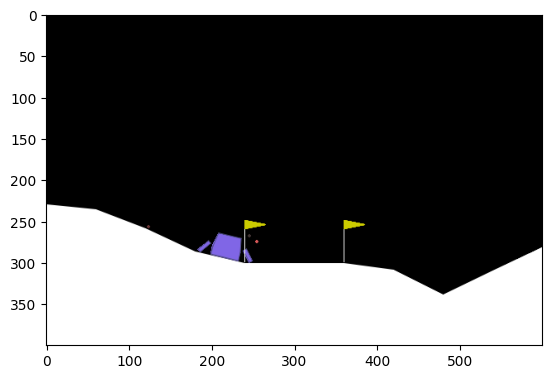

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

env.reset()
env_as_nparray = env.render(mode='rgb_array')
img = plt.imshow(env_as_nparray)
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [9]:
import torch.optim as optim
from torch.distributions import Categorical
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    # def forward(self, state):
    #     return self.network(state)
    def learn(self, log_probs, rewards):

        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def save(self, PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])

In [10]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

In [ ]:
# from torch.distributions import Categorical
# action_prob = torch.Tensor([0.1,0.2,0.3,0.4])
# action_dist = Categorical(action_prob)
# action = action_dist.sample()
# print(action)
# print(action_dist.log_prob(action))

In [ ]:
# Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
# If lander moves away from landing pad it loses reward back.
# Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
# Each leg ground contact is +10.
# Firing main engine is -0.3 points each frame.

In [18]:
# rewards = [1,2,3]
# reward = 4
# rewards.append(0)
# len_of_reward = len(rewards)
# rewards = [rewards[index] +(0.99)**(len_of_reward-index-1)*reward for index in range(len_of_reward)]
# print(rewards)

In [20]:
from tqdm.notebook import tqdm
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at(int) , log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            state = next_state
            total_reward += reward
            total_step += 1

            seq_rewards.append(0)
            len_of_seq_reward = len(seq_rewards)
            seq_rewards = [seq_rewards[index] +(0.99)**(len_of_seq_reward-(index+1))\
                    *reward for index in range(len_of_seq_reward)]

            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                rewards+=seq_rewards
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

    print(f"rewards looks like ", np.shape(rewards))
    print(f"log_probs looks like ", np.shape(torch.tensor(log_probs)))
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

  0%|          | 0/400 [00:00<?, ?it/s]

rewards looks like  (737,)
log_probs looks like  torch.Size([737])
logs prob looks like  torch.Size([737])
torch.from_numpy(rewards) looks like  torch.Size([737])
rewards looks like  (641,)
log_probs looks like  torch.Size([641])
logs prob looks like  torch.Size([641])
torch.from_numpy(rewards) looks like  torch.Size([641])
rewards looks like  (706,)
log_probs looks like  torch.Size([706])
logs prob looks like  torch.Size([706])
torch.from_numpy(rewards) looks like  torch.Size([706])
rewards looks like  (718,)
log_probs looks like  torch.Size([718])
logs prob looks like  torch.Size([718])
torch.from_numpy(rewards) looks like  torch.Size([718])
rewards looks like  (1883,)
log_probs looks like  torch.Size([1883])
logs prob looks like  torch.Size([1883])
torch.from_numpy(rewards) looks like  torch.Size([1883])
rewards looks like  (557,)
log_probs looks like  torch.Size([557])
logs prob looks like  torch.Size([557])
torch.from_numpy(rewards) looks like  torch.Size([557])
rewards looks like

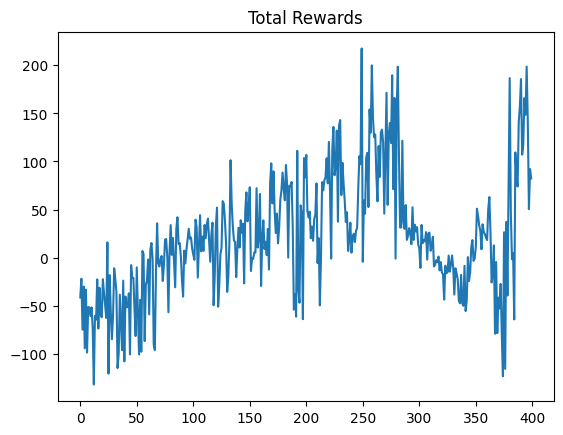

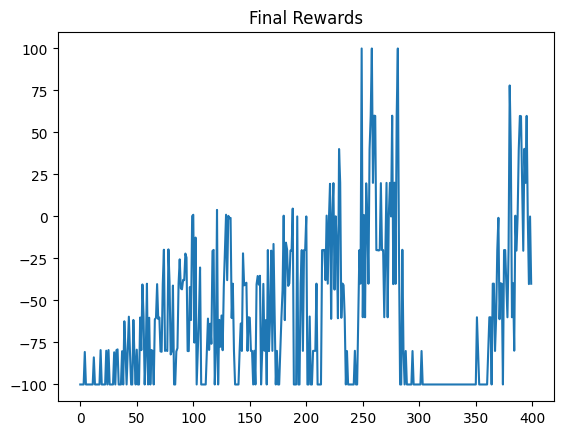

total time is 3156.1178436279297 sec


In [21]:
end = time.time()
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()
print(f"total time is {end-start} sec")

250.38425269388048
length of actions is  389


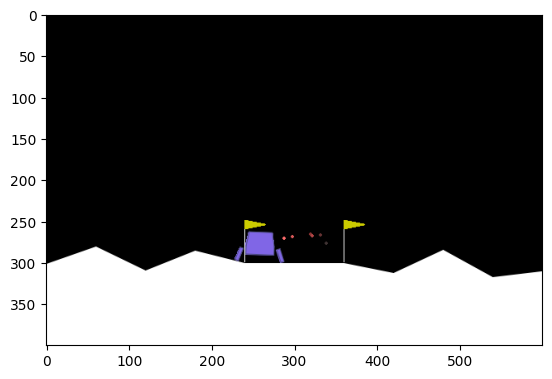

In [22]:
fix(env, seed)
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

In [23]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
print("Action list looks like ", action_list)
# set the max number of 0
max_len = max([len(x) for x in action_list])
temp = [x+ [-1]*max_len for x in action_list]
action_list_pad = [x[0:max_len] for x in temp]
print("Action list's shape looks like ", np.shape(action_list_pad))
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)
PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list_pad))

Your final reward is : 159.78
Action list looks like  [[2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 0, 3, 2, 1, 2, 2, 3, 2, 3, 3, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 1, 2, 3, 3, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 2, 1, 3, 2, 2, 3, 1, 2, 2, 3, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 3, 1, 2, 3, 2, 0, 2, 2, 3, 3, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 3, 1, 3, 0, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 2, 2, 2, 1, 1, 3, 2, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 0, 1, 3, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 0, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [24]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Your reward is : 250.38


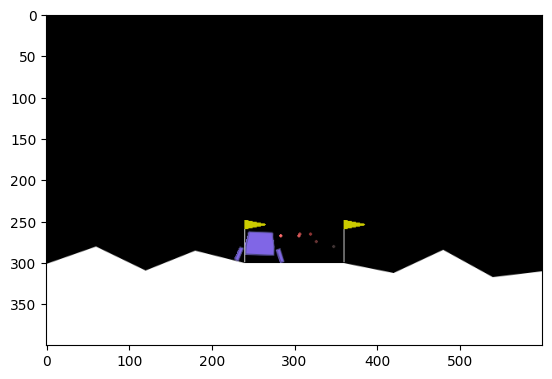

In [25]:
action_list_pad = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
action_list = [[x[i] for i in range(len(x)) if x[i]>=0] for x in action_list_pad]
seed = 543 #到時候測試的seed 請不要更改
fix(env, seed)

agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

test_total_reward = []
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  # while not done:
  done_count = 0
  for action in actions:
      # action, _ = agent1.sample(state)
      state, reward, done, _ = env.step(action)
      done_count += 1
      total_reward += reward
      if done:

        break
      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

In [26]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 159.78
